In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import argparse
from imutils import face_utils
import imutils
import dlib
import cv2

In [4]:
shape_predictor = "shape_predictor_68_face_landmarks.dat"

In [5]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)



In [6]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("./images/example_02.jpg")
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [7]:
# detect faces in the grayscale image
rects = detector(gray, 1)

In [8]:
# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    shape = shape[[34, 9, 37,46,49,55]]
    print(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # show the face number
    cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)

# show the output image with the face detections + facial landmarks


[[331 187]
 [332 256]
 [302 138]
 [366 151]
 [304 197]
 [340 220]]


In [9]:
def get_landmarks_2d(img):
    img = imutils.resize(img, width=500)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    # loop over the face detections
    shape = None
    face = None
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = img[ y:y+h,x:x+w, :]
        gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        
        shape = predictor(gray, rect)

        shape = face_utils.shape_to_np(shape)
        # Nose tip 34
        # Chin 9
        # Left eye left corner 37
        # Right eye right corne 46
        # Left Mouth corner 49
        # Right mouth corner 55
        shape = shape[[34, 9, 37,46,49,55]]

    return shape, face


In [10]:
shape, face = get_landmarks_2d(image)

In [11]:
face.shape

AttributeError: 'NoneType' object has no attribute 'shape'

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


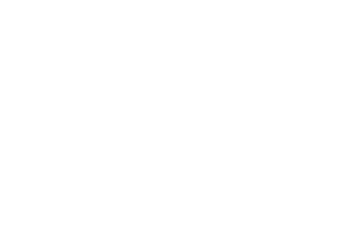

In [12]:
show_image(face)

In [13]:
def show_image(img):
    plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
show_image(image)

In [ ]:
Tip of the nose : ( 0.0, 0.0, 0.0) 34 
Chin : ( 0.0, -330.0, -65.0) 9
Left corner of the left eye : (-225.0f, 170.0f, -135.0) 37
Right corner of the right eye : ( 225.0, 170.0, -135.0) 46
Left corner of the mouth : (-150.0, -150.0, -125.0) 49 
Right corner of the mouth : (150.0, -150.0, -125.0) 55

In [ ]:
def get_6dovVector(im):
    size = im.shape

    #2D image points. If you change the image, you need to change vector
    image_points, face = get_landmarks_2d(im)
    image_points = image_points.astype(float)
    size = face.shape

    # 3D model points.
    model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner
                        ])


    # Camera internals

    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )

    print("Camera Matrix :\n {0}".format(camera_matrix))

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, cv2.SOLVEPNP_ITERATIVE)

    print("Rotation Vector:\n {0}".format(rotation_vector))
    print("Translation Vector:\n {0}".format(translation_vector))


    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose


    (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

    for p in image_points:
        cv2.circle(face, (int(p[0]), int(p[1])), 3, (0,0,255), -1)


    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

    cv2.line(face, p1, p2, (255,0,0), 2)
    
    show_image(face)

In [ ]:
image = cv2.imread("./images/example_02.jpg")

get_6dovVector(image)